In [1]:
import open3d as o3d
import numpy as np
import cv2, PIL
from PIL import Image
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import pandas as pd
import argparse
import imutils
import sys
import datetime as dt

%matplotlib nbagg

### Depth Image to Point Cloud Visualization with Open3d

In [2]:
class AzureKinect:
    def __init__(self):
        self.config = o3d.io.AzureKinectSensorConfig()
        self.device = 0
        self.align_depth_to_color = 1

    def start(self):
        self.sensor = o3d.io.AzureKinectSensor(self.config)
        if not self.sensor.connect(self.device):
            raise RuntimeError('Failed to connect to sensor')

    def frames(self):
            while 1:
                rgbd = self.sensor.capture_frame(self.align_depth_to_color)
                if rgbd is None:
                    continue
                color,depth = np.asarray(rgbd.color).astype(np.uint8),np.asarray(rgbd.depth).astype(np.float32) / 1000.0
                return color, depth
    #def stop(self):
     #   pause()

In [3]:
cam = AzureKinect()
cam.start()

AttributeError: module 'open3d.open3d.io' has no attribute 'AzureKinectSensorConfig'

In [4]:

b ol, depth = cam.frames()
intrinsic = o3d.camera.PinholeCameraIntrinsic(1280, 720, 601.1693115234375, 600.85931396484375, 637.83624267578125, 363.8018798828125)
depth = o3d.geometry.Image(depth)
img = o3d.geometry.Image(color)
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(img, depth, depth_scale=1.0, convert_rgb_to_intensity=False)
#pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
#o3d.visualization.draw_geometries([pcd])

SyntaxError: invalid syntax (<ipython-input-4-0c6014fdcf81>, line 1)

<IPython.core.display.Javascript object>


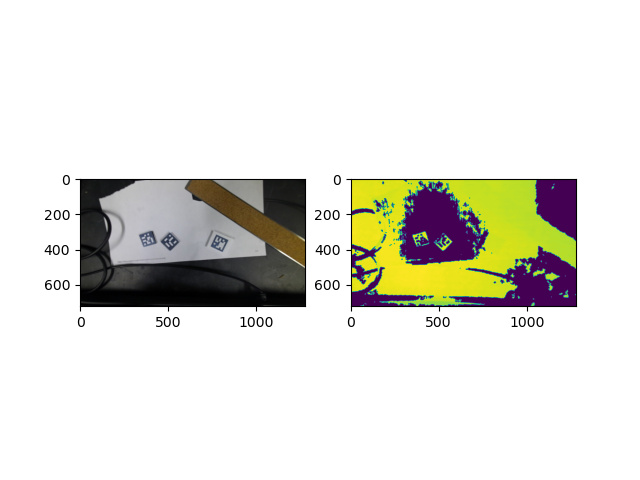

In [23]:
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(rgbd.color)
fig.add_subplot(1, 2, 2)
plt.imshow(rgbd.depth)
plt.show()

In [24]:
color_array = np.asarray(rgbd.color)
depth_array = np.asarray(rgbd.depth)
color_img = Image.fromarray(color_array)
depth_img = Image.fromarray(depth_array)
color_img.save("color.jpg")

### Aruco Marker Detection with OpenCV

Generate the Aruco marker dictionary

In [5]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 4
ny = 3
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i, 300)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("./markers.pdf")
plt.show()

<IPython.core.display.Javascript object>

In [6]:
ARUCO_DICT = {
	"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
	"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
	"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
	"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
	"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
	"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
	"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
	"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
	"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}

In [7]:
# load the input image from disk and resize it
print("[INFO] loading image...")
image = cv2.imread("./color.jpg")
image = imutils.resize(image, width=600)
# loop over the types of ArUco dictionaries
for (arucoName, arucoDict) in ARUCO_DICT.items():
    # load the ArUCo dictionary, grab the ArUCo parameters, and
    # attempt to detect the markers for the current dictionary
    arucoDict = cv2.aruco.Dictionary_get(arucoDict)
    arucoParams = cv2.aruco.DetectorParameters_create()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(
        image, arucoDict, parameters=arucoParams)
    # if at least one ArUco marker was detected display the ArUco
    # name to our terminal
    if len(corners) > 0:
        print("[INFO] detected {} markers for '{}'".format(
            len(corners), arucoName))


[INFO] loading image...


Print and take a picture

In [8]:
#frame = cv2.imread("./aruco_print.jpg")
frame = cv2.imread("./color.jpg")
plt.figure()
plt.imshow(frame)
plt.show()

<IPython.core.display.Javascript object>

Post processing

In [9]:
%%time
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

Wall time: 45 ms


Display results

In [10]:
id_centers = {}
if ids is not None:
    plt.figure()
    plt.imshow(frame_markers)
    for i in range(len(ids)):
        c = corners[i][0]
        plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
        id_centers[ids[i][0]] = (c[:, 0].mean(), c[:, 1].mean())
    plt.legend()
    plt.show()


In [11]:
id_centers

{}

In [12]:
def marker_depth(id_centers, depth_array):
    output = {}
    for key in id_centers:
        center_x = round(id_centers[key][0]) 
        center_y = round(id_centers[key][1])
        output[key] = depth_array[center_y][center_x]*100 #cm
    return output

In [13]:
marker_depth(id_centers, depth_array)

NameError: name 'depth_array' is not defined

In [49]:
# This function is called periodically from FuncAnimation
def animate(i, xs, ys):

    # Read depth from Kinect
    color, depth = cam.frames()
    intrinsic = o3d.camera.PinholeCameraIntrinsic(1280, 720, 601.1693115234375, 600.85931396484375, 637.83624267578125, 363.8018798828125)
    depth = o3d.geometry.Image(depth)
    img = o3d.geometry.Image(color)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(img, depth, depth_scale=1.0, convert_rgb_to_intensity=False)
    
    #to array
    color_array = np.asarray(rgbd.color)
    depth_array = np.asarray(rgbd.depth)
    color_img = Image.fromarray(color_array)
    depth_img = Image.fromarray(depth_array)
    color_img.save("color.jpg")
    
    #aruco detection
    frame = cv2.imread("./color.jpg")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
    
    #aruco visualization
    id_centers = {}
    if ids is not None:
        #plt.figure()
        #plt.imshow(frame_markers)
        for i in range(len(ids)):
            c = corners[i][0]
            #plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
            id_centers[ids[i][0]] = (c[:, 0].mean(), c[:, 1].mean())
        #plt.legend()
        #plt.show()
    depth_dict = marker_depth(id_centers, depth_array)
    if bool(depth_dict): 
        depth_avg = sum(depth_dict.values())/len(depth_dict.values())
    else:
        depth_avg = 0
    
    #depth_c = round(tmp102.read_temp(), 2)

    # Add x and y to lists
    xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
    ys.append(depth_avg)

    # Limit x and y lists to 20 items
    xs = xs[-20:]
    ys = ys[-20:]

    # Draw x and y lists
    ax_rt.clear()
    ax_rt.plot(xs, ys)

    # Format plot
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)
    plt.title('Depth over Time')
    plt.ylabel('Average depth of markers (cm)')


<IPython.core.display.Javascript object>


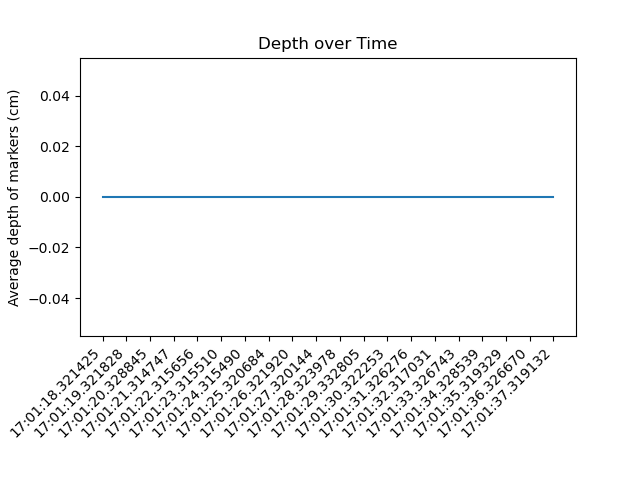

In [50]:
#create figure for plotting
fig_rt = plt.figure()
ax_rt = fig_rt.add_subplot(1, 1, 1)
xs = []
ys = []
# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig_rt, animate, fargs=(xs, ys), interval=1000)
plt.show()

In [53]:
cam.device_stop_cameras()
cam.device_close()

AttributeError: 'AzureKinect' object has no attribute 'device_stop_cameras'

INFO - 2021-07-20 16:49:56,330 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 2021-07-20 16:49:56,332 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<IPython.core.display.Javascript object>


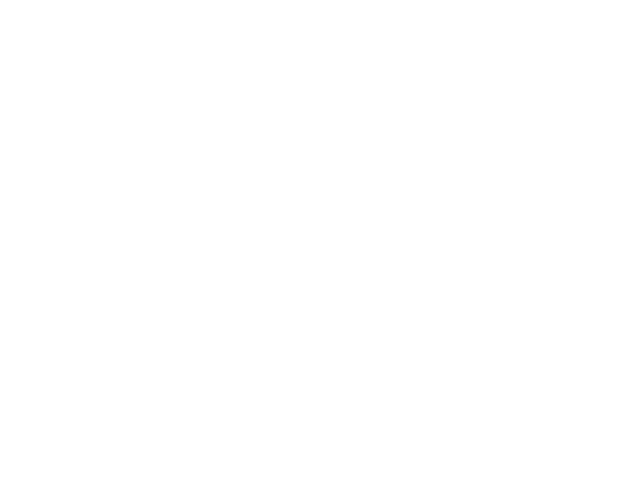

KeyboardInterrupt: 

In [39]:
while cv2.waitKey(1) & 0xFF != ord('q'):
    
    color, depth = cam.frames()
    intrinsic = o3d.camera.PinholeCameraIntrinsic(1280, 720, 601.1693115234375, 600.85931396484375, 637.83624267578125, 363.8018798828125)
    depth = o3d.geometry.Image(depth)
    img = o3d.geometry.Image(color)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(img, depth, depth_scale=1.0, convert_rgb_to_intensity=False)
    
    #to array
    color_array = np.asarray(rgbd.color)
    depth_array = np.asarray(rgbd.depth)
    color_img = Image.fromarray(color_array)
    depth_img = Image.fromarray(depth_array)
    color_img.save("color.jpg")
    
    #aruco detection
    frame = cv2.imread("./color.jpg")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
    
    #aruco visualization
    id_centers = {}
    if ids is not None:
        #plt.figure()
        #plt.imshow(frame_markers)
        for i in range(len(ids)):
            c = corners[i][0]
            #plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
            id_centers[ids[i][0]] = (c[:, 0].mean(), c[:, 1].mean())
        #plt.legend()
        #plt.show()
    depth_dict = marker_depth(id_centers, depth_array)
    depth_avg = sum(depth_dict.values())/len(depth_dict.values())

In [55]:
cam.close()

AttributeError: 'AzureKinect' object has no attribute 'close'

INFO - 2021-07-20 16:57:42,331 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO - 2021-07-20 16:57:42,332 - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
